# !pip install pycocotools

* https://github.com/little51/dinov3-train

In [1]:
import torch.nn as nn  ## torch neural network
import timm  ## timm is a library for vision model 
import torchvision
from torchvision import datasets  # lib to load torchvision model
import torch  # torch
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
from tqdm import tqdm

REPO_DIR = "/home/yang/MyRepos/dinov3"

/home/yang/miniconda3/envs/dinov3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load backbone model
* Note that it uses num_classes=0 to disable classification head of the backbone
* It freezes all the parameters to prevent back-propagate

In [3]:
def load_model():
    # list all timm supported models
    model_list = timm.list_models()
    print(model_list)
    
    # timm.create_model is used to load pretrained vision model, pretrained to determine if load weights, #coco has 91 number of classes
    # model = timm.create_model('timm/vit_small_patch16_dinov3.lvd1689m', pretrained=True, num_classes=0, dynamic_img_size=True)
    model = timm.create_model('timm/vit_large_patch16_dinov3.lvd1689m', pretrained=True, num_classes=0, dynamic_img_size=True)
    # print(model)
    # vit_large_patch16_dinov3
    
    input_temp = torch.randn((1, 3, 256, 256))
    print(f"mode output shape is {model(input_temp).shape}") # get the shape of the output
    
    # timm.create_model is used to
    model.eval()  # set the model in evaluation mode
    for param in model.parameters():
        param.requires_grad = False
    print("model loaded")
    print(sum(param.numel() for param in model.parameters())/1000000)
    return model

model = load_model()

['aimv2_1b_patch14_224', 'aimv2_1b_patch14_336', 'aimv2_1b_patch14_448', 'aimv2_3b_patch14_224', 'aimv2_3b_patch14_336', 'aimv2_3b_patch14_448', 'aimv2_huge_patch14_224', 'aimv2_huge_patch14_336', 'aimv2_huge_patch14_448', 'aimv2_large_patch14_224', 'aimv2_large_patch14_336', 'aimv2_large_patch14_448', 'bat_resnext26ts', 'beit3_base_patch16_224', 'beit3_giant_patch14_224', 'beit3_giant_patch14_336', 'beit3_large_patch16_224', 'beit_base_patch16_224', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_384', 'beit_large_patch16_512', 'beitv2_base_patch16_224', 'beitv2_large_patch16_224', 'botnet26t_256', 'botnet50ts_256', 'caformer_b36', 'caformer_m36', 'caformer_s18', 'caformer_s36', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_medium', 'coat_lite_medium_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_s

# Define detection model

In [4]:
class Dinov3DetectionModel(nn.Module):

    def __init__(self, backbone_name = 'vit_large_patch16_dinov3.lvd1689m', num_classes = 91):
        super().__init__()
        # load the backbone from pretrained model
        self.backbone = timm.create_model(
            backbone_name,
            pretrained=True,
            num_classes = 0,
            dynamic_img_size = True
        )

        # freeze the backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False

        # obtain the feature dimension
        with torch.no_grad():
            dummy_input = torch.randn((1, 3, 256, 256))
            features = self.backbone(dummy_input)
            self.feature_dim = features.shape[1]
            print(f"Dinov3 feature dimension is {features.shape}")

        # define object detection head
        self.detection_head = nn.Sequential(
            nn.Linear(self.feature_dim, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes * 5) # for each class has (x,y,w,h) + confidency, there 5 dimensions for each class
        )

    def forward(self, x):
        features = self.backbone(x)  # [B, C]
        detection_output = self.detection_head(
            features
        ) # [B, num_classes *5]
        return detection_output

model = Dinov3DetectionModel()
print(model)

Dinov3 feature dimension is torch.Size([1, 1024])
Dinov3DetectionModel(
  (backbone): Eva(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rope): RotaryEmbeddingDinoV3()
    (norm_pre): Identity()
    (blocks): ModuleList(
      (0-23): 24 x EvaBlock(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): EvaAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_feature

# Load Dataset
* load COCO 2017 dataset, it has 80 object classes, however, it has non-continuous id, therefore 91 ids
* https://cocodataset.org/#detection-2017
* manually download with FireFox web-browser
* manually download "2017 Train/Val annotations [241MB]" from https://cocodataset.org/#download
* manually download "2017 Train images [118K/18GB]" from https://cocodataset.org/#download
* manually download "2017 Val images [5K/1GB]" from https://cocodataset.org/#download

# Plot one image and check image tensor

In [5]:
from torchvision import transforms
from torchvision.transforms import ToPILImage

totensor_transform = transforms.ToTensor()

train_dataset = datasets.CocoDetection(
    root = "./data/coco/train2017",
    annFile = "./data/coco/annotations/instances_train2017.json"
)
print(train_dataset[0])
print("--------------------------------------------------------------")
print(f"bbox is : {train_dataset[0][1][0]['bbox']}")  
# 1st 0 means first image from the data set, 2nd 1 means the annotated target of the image, 3rd 0 means the first object of all objects
print(f"category id is: {train_dataset[0][1][0]['category_id']}")
img_pil = train_dataset[0][0]
print(img_pil.size)
img_pil.show()
img_tensor = totensor_transform(img_pil)
print(img_tensor.shape)

loading annotations into memory...
Done (t=7.29s)
creating index...
index created!
(<PIL.Image.Image image mode=RGB size=640x480 at 0x7C73B535D760>, [{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257

In [6]:
print(len(train_dataset))

118287


In [7]:
# Process data to add image size to target
from concurrent.futures import ProcessPoolExecutor
import concurrent.futures
import json

def add_size(train_dataset, i):
    width, height = train_dataset[i][0].size
    # print(f"{i}'s item with width {width} and height {height}  ")
    if len(train_dataset[i][1]) > 0:
        train_dataset[i][1][0]['size'] = (width, height)

with ProcessPoolExecutor(max_workers=12) as executor:
    for i in range(10):
        executor.submit(add_size, train_dataset, i)
    
# for i in range(10):
#     add_size(train_dataset, i)

print("---------------------------------------------")
print('Done processing')
print(train_dataset[0])

---------------------------------------------
Done processing
(<PIL.Image.Image image mode=RGB size=640x480 at 0x7C73B540FF20>, [{'segmentation': [[500.49, 473.53, 599.73, 419.6, 612.67, 375.37, 608.36, 354.88, 528.54, 269.66, 457.35, 201.71, 420.67, 187.69, 389.39, 192.0, 19.42, 360.27, 1.08, 389.39, 2.16, 427.15, 20.49, 473.53]], 'area': 120057.13925, 'iscrowd': 0, 'image_id': 9, 'bbox': [1.08, 187.69, 611.59, 285.84], 'category_id': 51, 'id': 1038967}, {'segmentation': [[357.03, 69.03, 311.73, 15.1, 550.11, 4.31, 631.01, 62.56, 629.93, 88.45, 595.42, 185.53, 513.44, 230.83, 488.63, 232.99, 437.93, 190.92, 429.3, 189.84, 434.7, 148.85, 410.97, 121.89, 359.19, 74.43, 358.11, 65.8]], 'area': 44434.751099999994, 'iscrowd': 0, 'image_id': 9, 'bbox': [311.73, 4.31, 319.28, 228.68], 'category_id': 51, 'id': 1039564}, {'segmentation': [[249.6, 348.99, 267.67, 311.72, 291.39, 294.78, 304.94, 294.78, 326.4, 283.48, 345.6, 273.32, 368.19, 269.93, 385.13, 268.8, 388.52, 257.51, 393.04, 250.73, 

# Create Dataloader

In [8]:
# !pip install git+https://github.com/waleedka/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI

def collate_fn(batch):
    """process COCO dataset"""
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])

    images = []
    targets = []

    for img, target in batch:
        width, height = img.size
        images.append(transform(img))
        # only take the label from the first object
        if len(target) > 0:
            bbox = [
                target[0]['bbox'][0]/width,
                target[0]['bbox'][1]/height,
                target[0]['bbox'][2]/width,
                target[0]['bbox'][3]/height
            ] # [x, y, w, h]
            category_id = target[0]['category_id']
            targets.append({
                'bbox': torch.tensor(bbox, dtype = torch.float32),
                'category_id': torch.tensor(category_id, dtype = torch.long)
            })
        else:
            # use default value if there is no object
            targets.append({
                'bbox': torch.tensor([0, 0, 1, 1], dtype = torch.float32),
                'category_id': torch.tensor(0, dtype = torch.long)
            })

    return torch.stack(images), targets

def load_coco_dataset(batch_size = 8):
    """load COCO 2017 dataset"""
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])

    # load COCO data
    train_dataset = datasets.CocoDetection(
        root = "./data/coco/train2017",
        annFile = "./data/coco/annotations/instances_train2017.json",
        # transform = transform
    )

    val_dataset = datasets.CocoDetection(
        root="./data/coco/val2017",
        annFile="./data/coco/annotations/instances_val2017.json",
        # transform=transform
    )
            
    train_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size, 
        shuffle = False,
        num_workers = 12,
        collate_fn = collate_fn # the data has varying sizes (e.g. the number of objects in a image varies). This function only picks the 1st object to unify the data size
    )

    val_loader = DataLoader(
        val_dataset, 
        batch_size = batch_size, 
        shuffle = False,
        num_workers = 12,
        collate_fn = collate_fn
    )

    print(f"CoCo dataset is loaded")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")

    return train_loader, val_loader

train_loader, val_loader = load_coco_dataset(8)

loading annotations into memory...
Done (t=7.46s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
CoCo dataset is loaded
Train dataset size: 118287
Validation dataset size: 5000


# Define Loss function
* class loss use CrossEntropyLoss()
* bbox loss use MSELoss()

In [9]:
def loss_fn(predictions, targets, num_classes=91):
    batch_size = predictions.shape[0]
    predictions = predictions.view(batch_size, num_classes, 5)

    mse_loss = nn.MSELoss()
    entropy_loss = nn.CrossEntropyLoss()
    
    bbox_loss = 0 # detection loss
    cls_loss = 0 # classification lossS

    for i, target in enumerate(targets):
        # move target and predictions to the same device
        gt_bbox = target['bbox'].to(predictions.device)
        gt_cls = target['category_id'].to(predictions.device)

        # bbox loss
        pred_bbox = predictions[i, target['category_id'], :4] 
        # predicted bounding box, prediction has a dimension of 5, 0-3 is bbox, 4 is class
        bbox_loss += mse_loss(pred_bbox, gt_bbox)

        # classification loss
        pred_cls = predictions[i, :, 4]
        cls_loss += entropy_loss(pred_cls.unsqueeze(0), gt_cls.unsqueeze(0))

    total_loss = (bbox_loss + cls_loss) / batch_size
    return total_loss

# Train function

In [10]:
def train_detection_model(model, train_loader, val_loader, num_epochs = 10):
    """train the detection model"""
    model.to(device)
    # criterion = DetectionLoss(num_classes=91)
    optimizer = optim.AdamW(model.detection_head.parameters(), lr=0.001, weight_decay = 0.01)
    scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

    print("start model training")

    for epoch in range(num_epochs):
        # train 
        model.train()
        epoch_loss = 0.0
        train_bar = tqdm(train_loader, desc = f"Epoch {epoch+1}/{num_epochs}")

        for images, targets in train_bar:
            # print(targets)
            images = images.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, targets)
            # loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            train_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

        avg_loss = epoch_loss / len(train_loader)
        scheduler.step()

        print(f"Epoch {epoch+1}: Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")

        # save checkpoint
        if (epoch + 1) % 5 == 0:
            torch.save(
                model.detection_head.state_dict(),
                f"coco_detection_head_epoch{epoch+1}.pth"
            )

    return model

# Train model

In [11]:
# Train the detection model head
trained_model = train_detection_model(model, train_loader, val_loader, num_epochs=20)

# save the trained model
torch.save(trained_model.detection_head.state_dict(), 'final_coco_detection_head.pth')

print("-----------------------successfully trained model------------------------------")

start model training


Epoch 1/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:58<00:00,  7.05it/s, Loss=1.0106]


Epoch 1: Loss: 1.4215, LR: 0.000994


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [35:05<00:00,  7.02it/s, Loss=1.2313]


Epoch 2: Loss: 1.2122, LR: 0.000976


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [35:02<00:00,  7.03it/s, Loss=1.0819]


Epoch 3: Loss: 1.1548, LR: 0.000946


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:56<00:00,  7.05it/s, Loss=1.4538]


Epoch 4: Loss: 1.1153, LR: 0.000905


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:58<00:00,  7.05it/s, Loss=1.4578]


Epoch 5: Loss: 1.0839, LR: 0.000854


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [35:01<00:00,  7.04it/s, Loss=0.8290]


Epoch 6: Loss: 1.0497, LR: 0.000794


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:59<00:00,  7.04it/s, Loss=0.9531]


Epoch 7: Loss: 1.0131, LR: 0.000727


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [35:01<00:00,  7.04it/s, Loss=1.2948]


Epoch 8: Loss: 0.9786, LR: 0.000655


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:53<00:00,  7.06it/s, Loss=1.1080]


Epoch 9: Loss: 0.9387, LR: 0.000578


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:52<00:00,  7.07it/s, Loss=0.7044]


Epoch 10: Loss: 0.8920, LR: 0.000500


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [35:02<00:00,  7.03it/s, Loss=1.2867]


Epoch 11: Loss: 0.8448, LR: 0.000422


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [35:01<00:00,  7.04it/s, Loss=1.0138]


Epoch 12: Loss: 0.7921, LR: 0.000345


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:56<00:00,  7.05it/s, Loss=0.6379]


Epoch 13: Loss: 0.7375, LR: 0.000273


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:59<00:00,  7.04it/s, Loss=0.9098]


Epoch 14: Loss: 0.6892, LR: 0.000206


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:58<00:00,  7.05it/s, Loss=0.3974]


Epoch 15: Loss: 0.6404, LR: 0.000146


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [35:00<00:00,  7.04it/s, Loss=0.7850]


Epoch 16: Loss: 0.5969, LR: 0.000095


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [34:54<00:00,  7.06it/s, Loss=0.3712]


Epoch 17: Loss: 0.5633, LR: 0.000054


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [31:37<00:00,  7.79it/s, Loss=0.4409]


Epoch 18: Loss: 0.5374, LR: 0.000024


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [17:02<00:00, 14.45it/s, Loss=0.4670]


Epoch 19: Loss: 0.5199, LR: 0.000006


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 14786/14786 [16:55<00:00, 14.56it/s, Loss=0.2104]

Epoch 20: Loss: 0.5120, LR: 0.000000
-----------------------successfully trained model------------------------------


In [12]:
trained_model = torch.load('final_coco_detection_head.pth')
# print(trained_model)

/tmp/ipykernel_249281/3546965406.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load('final_coco_detection_head.pth')


# Inference

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import os

* id conversion

In [14]:
# COCO classes
COCO_CLASSES = [
    'background', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag',
    'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite',
    'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
    'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
    'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock',
    'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]
# COCO ids
COCO_ID_TO_CONTINUOUS_ID = {
    1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10,
    11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20,
    22: 21, 23: 22, 24: 23, 25: 24, 27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30,
    35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40,
    46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50,
    56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60,
    67: 61, 70: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70,
    80: 71, 81: 72, 82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80
}
# get the id to class mapping
CONTINUOUS_ID_TO_COCO_ID = {v: k for k, v in COCO_ID_TO_CONTINUOUS_ID.items()}

MODEL_OUTPUT_TO_COCO_ID = {}
MODEL_OUTPUT_TO_COCO_ID[0] = 0

for coco_id, continuous_id in COCO_ID_TO_CONTINUOUS_ID.items():
    MODEL_OUTPUT_TO_COCO_ID[coco_id] = continuous_id

# COCO ID
non_existent_ids = [12, 26, 29, 30, 45, 66, 68, 69, 71, 83]
for invalid_id in non_existent_ids:
    MODEL_OUTPUT_TO_COCO_ID[invalid_id] = 0

print(MODEL_OUTPUT_TO_COCO_ID)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 13: 12, 14: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 27: 25, 28: 26, 31: 27, 32: 28, 33: 29, 34: 30, 35: 31, 36: 32, 37: 33, 38: 34, 39: 35, 40: 36, 41: 37, 42: 38, 43: 39, 44: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 51: 46, 52: 47, 53: 48, 54: 49, 55: 50, 56: 51, 57: 52, 58: 53, 59: 54, 60: 55, 61: 56, 62: 57, 63: 58, 64: 59, 65: 60, 67: 61, 70: 62, 72: 63, 73: 64, 74: 65, 75: 66, 76: 67, 77: 68, 78: 69, 79: 70, 80: 71, 81: 72, 82: 73, 84: 74, 85: 75, 86: 76, 87: 77, 88: 78, 89: 79, 90: 80, 12: 0, 26: 0, 29: 0, 30: 0, 45: 0, 66: 0, 68: 0, 69: 0, 71: 0, 83: 0}


* load model

In [15]:
model_path = "./final_coco_detection_head.pth"

model = Dinov3DetectionModel()
print(model.parameters)
print("--------------------------------------------------")
num_parameters = (sum(param.numel() for param in model.parameters()))/1000000000
print(f"model number of parameters is {num_parameters} B")

model.detection_head.load_state_dict(
    torch.load(model_path, map_location=device)
)
model.to(device)
model.eval()

print(f"model is loaded {model_path}")

Dinov3 feature dimension is torch.Size([1, 1024])
<bound method Module.parameters of Dinov3DetectionModel(
  (backbone): Eva(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rope): RotaryEmbeddingDinoV3()
    (norm_pre): Identity()
    (blocks): ModuleList(
      (0-23): 24 x EvaBlock(
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): EvaAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(

/tmp/ipykernel_249281/982147691.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path, map_location=device)


* preprocess image

In [135]:
def preprocess_image(image_path):
    """transform and to tensor"""
    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.224, 0.225]
        )
    ])

    image_pil = Image.open(image_path).convert('RGB')
    original_size = image_pil.size

    # processed image
    processed_image = transform(image_pil).unsqueeze(0)  # add a batch dimension

    return processed_image, image_pil, original_size

image_path = '/home/yang/MyRepos/dinov3/tutorial_notebooks/data/coco/val2017/000000000285.jpg'
image_path = '/home/yang/MyRepos/dinov3/tutorial_notebooks/data/coco/val2017/000000000785.jpg'
image_path = '/home/yang/MyRepos/dinov3/tutorial_notebooks/data/coco/val2017/000000001296.jpg'
# image_path = '/home/yang/MyRepos/dinov3/tutorial_notebooks/data/coco/val2017/000000002149.jpg'
# 000000001296

# 000000000139.jpg  000000147729.jpg  000000289594.jpg  000000435206.jpg
# 000000000285.jpg  000000147740.jpg  000000289659.jpg  000000435208.jpg
# 000000000632.jpg  000000147745.jpg  000000289702.jpg  000000435299.jpg
# 000000000724.jpg  000000148508.jpg  000000289741.jpg  000000435880.jpg
# 000000000776.jpg  000000148620.jpg  000000289938.jpg  000000436315.jpg
# 000000000785.jpg  000000148662.jpg  000000289960.jpg  000000436551.jpg
# 000000000802.jpg  000000148707.jpg  000000289992.jpg  000000436617.jpg
# 000000000872.jpg  000000148719.jpg  000000290081.jpg  000000436738.jpg
# 000000000885.jpg  000000148730.jpg  000000290163.jpg  000000436883.jpg
# 000000001000.jpg  000000148739.jpg  000000290179.jpg  000000437110.jpg
# 000000001268.jpg  000000148783.jpg  000000290248.jpg  000000437205.jpg
image_path = '/home/yang/MyRepos/dinov3/tutorial_notebooks/data/coco/val2017/000000148730.jpg'

processed_image, original_image, original_size = preprocess_image(image_path)

original_image.show()
print(processed_image)
print(original_size)
print(processed_image.shape)

tensor([[[[2.0434, 2.0434, 2.0263,  ..., 2.0605, 2.0605, 2.0434],
          [2.0263, 2.0434, 2.0434,  ..., 2.0605, 2.0434, 2.0605],
          [2.0263, 2.0434, 2.0263,  ..., 2.0434, 2.0434, 2.0605],
          ...,
          [1.9578, 1.9578, 1.9578,  ..., 1.9749, 1.9749, 1.9749],
          [1.9578, 1.9578, 1.9578,  ..., 1.9749, 1.9578, 1.9749],
          [1.9578, 1.9578, 1.9578,  ..., 1.9920, 1.9749, 1.9578]],

         [[1.7983, 1.7983, 1.7808,  ..., 1.8158, 1.8158, 1.7983],
          [1.7808, 1.7983, 1.7983,  ..., 1.8158, 1.7983, 1.8158],
          [1.7808, 1.7983, 1.7808,  ..., 1.7983, 1.7983, 1.8158],
          ...,
          [1.7108, 1.7108, 1.7108,  ..., 1.7808, 1.7458, 1.7283],
          [1.7108, 1.7108, 1.7283,  ..., 1.7458, 1.7283, 1.7283],
          [1.7283, 1.7283, 1.7283,  ..., 1.7458, 1.7283, 1.7108]],

         [[1.5245, 1.5245, 1.5071,  ..., 1.5420, 1.5420, 1.5245],
          [1.5071, 1.5245, 1.5245,  ..., 1.5420, 1.5245, 1.5420],
          [1.5071, 1.5245, 1.5071,  ..., 1

In [136]:
def draw_bbox(image_path, bboxs, labels, new_size = (1000, 600)):
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")

    # Resize the image
    image = image.resize(new_size)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label in zip(bboxs, labels):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle((x_min, y_min),
            width,
            height,
            linewidth = 2,
            edgecolor = 'r',
            facecolor = 'none'
        )
        ax.add_patch(rect)
        plt.text(
            x_min, 
            y_min, 
            f"{label}", 
            color='white', 
            fontsize=12,
            bbox = dict(facecolor='red', alpha=0.5)
        )

    plt.axis('off')
    plt.show()

In [137]:
with torch.no_grad():
    predictions = model(processed_image.to(device))
predictions = predictions.view(1, 91, 5)
# print(predictions)
print(predictions.shape[0])
print(predictions.shape) #[batch, 91 classes, 5 dimension]
class_predictions = predictions[0, 2]
print(class_predictions)

1
torch.Size([1, 91, 5])
tensor([  0.2599,   0.6099,  -0.1247,  -0.2374, -32.0214], device='cuda:0')


(640, 427)
[{'class_id': 9, 'continuous_id': 9, 'class_name': 'boat', 'bbox': [np.float32(162.31296), np.float32(162.2561), np.float32(507.7207), np.float32(349.05383)], 'confidence': 0.9999401569366455, 'model_output_id': 9}]


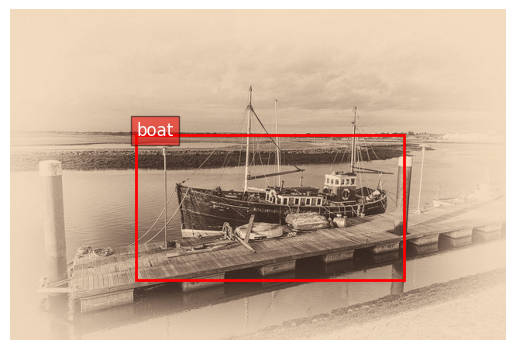

In [138]:
def post_processing(predictions, original_size, confidence_threshold=0.8):
    batch_size = predictions.shape[0]
    predictions = predictions.view(batch_size, 91, 5) #[batch, 91 classes, 5 dimension]

    detections = []

    confidence_tensor = torch.softmax(predictions[0, :,4], dim=0)

    for model_output_id in range(91):
        class_predictions = predictions[0, model_output_id]  # get the model_output_id row of the tensor

        confidence = confidence_tensor[model_output_id].item()

        if confidence > confidence_threshold: # detected a object
            continuous_id = MODEL_OUTPUT_TO_COCO_ID.get(model_output_id, 0)

            # if it is 0, skip (background)
            if continuous_id == 0:
                continue

            # get oringial id
            coco_id = CONTINUOUS_ID_TO_COCO_ID.get(continuous_id, 0)
            if coco_id == 0:
                continue

            x, y, w, h = class_predictions[:4].cpu().detach().numpy()

            # resize to original size
            img_width, img_height = original_size
            x = x * img_width
            y = y * img_height
            w = w * img_width
            h = h * img_height

            x1, y1, x2, y2 = class_predictions[:4].cpu().detach().numpy()

            x1 = max(0, x)
            y1 = max(0, y)
            x2 = min(img_width, x + w)
            y2 = min(img_height, y + h)

            detection = {
                'class_id': coco_id,
                'continuous_id': continuous_id,
                'class_name': COCO_CLASSES[continuous_id],
                'bbox': [x1, y1, x2, y2],
                'confidence': confidence,
                'model_output_id': model_output_id
            }
            detections.append(detection)

    detections.sort(key=lambda x: x['confidence'], reverse = True)

    return detections

print(original_size)
results = post_processing(predictions, original_size, confidence_threshold=0.5)
print(results)

bboxs = [detect_object['bbox'] for detect_object in results]
labels = [detect_object['class_name'] for detect_object in results]
draw_bbox(image_path, bboxs, labels, new_size = original_size)

In [130]:
x = torch.tensor([1, 2, 3, 4])
y = torch.unsqueeze(x, 0)
z = torch.unsqueeze(x, 1)
print(x)
print(y)
print(z)
x_min, y_min, x_max, y_max = x
print(x_min.tolist())

tensor([1, 2, 3, 4])
tensor([[1, 2, 3, 4]])
tensor([[1],
        [2],
        [3],
        [4]])
1
